# Project 3: Implementing a Simple Recurrent Neural Network (RNN)

## Introduction

In this project, you will design, implement, and evaluate a simple Recurrent Neural Network (RNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Convolutional Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

## Dataset

You are free to choose any dataset for this project! Kaggle would be a good source to look for datasets. Below are some examples:
- Daily Minimum Temperatures in Melbourne: This dataset contains the daily minimum temperatures in Melbourne, Australia, from 1981 to 1990.
- Daily Bitcoin Prices: This dataset contains historical daily prices of Bitcoin, which can be used for time series forecasting projects.
- Text8 Dataset: This dataset consists of the first 100 million characters from Wikipedia. It's great for text generation or language modeling tasks.
- IMDB Movie Reviews: This dataset contains 50,000 movie reviews for sentiment analysis, split evenly into 25,000 training and 25,000 test sets.
- Jena Climate Dataset: This dataset records various weather attributes (temperature, pressure, humidity, etc.) every 10 minutes, making it ideal for time series analysis.
- Earthquake Aftershocks: This dataset contains seismic data, suitable for predicting aftershocks following major earthquakes.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re
from collections import Counter

In [2]:
# Load and preprocess the dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df['review'].tolist(), df['sentiment'].tolist()

In [3]:
def preprocess_text(text):
    text = re.sub(r'<br /><br />', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)        # Remove punctuation
    return text.lower().split()

In [13]:
# Define the custom dataset for movie reviews
class MovieReviewDataset(Dataset):
    def __init__(self, reviews, sentiments):
        # Preprocess reviews and convert sentiments into binary format
        self.reviews = [preprocess_text(review) for review in reviews]
        self.sentiments = [1 if sentiment == 'positive' else 0 for sentiment in sentiments]

    #building vocabulary from reviews
        word_counts = Counter(word for review in self.reviews for word in review)
        self.vocab = {word: i+1 for i, word in enumerate(word_counts)}  # start indexing from 1

        # Map words in reviews to integers based on the vocabulary
        self.encoded_reviews = [[self.vocab[word] for word in review if word in self.vocab] for review in self.reviews]

    def __len__(self):
        # Return the total number of reviews
        return len(self.reviews)

    def __getitem__(self, idx):
        # Fetch the processed review and its sentiment by index
        return torch.tensor(self.encoded_reviews[idx], dtype=torch.long), self.sentiments[idx]

def collate_fn(batch):
    # Helper function to pad the reviews so they all have the same length
    reviews, sentiments = zip(*batch)
    reviews = pad_sequence(reviews, batch_first=True, padding_value=0)
    return reviews, torch.tensor(sentiments, dtype=torch.float32)

# Define the simple RNN model
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SimpleRNN, self).__init__()
        # Embedding layer to transform indices into dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Recurrent layer to process sequences of embeddings
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        # Output layer to predict the sentiment from the last RNN output
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        # Define the forward pass through the network
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        return torch.sigmoid(self.fc(hidden[-1]))

# Check and use GPU if available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA not available. Training on CPU.")

# Load data and prepare datasets and loaders
reviews, sentiments = load_data('IMDB_Dataset.csv')
dataset = MovieReviewDataset(reviews, sentiments)
vocab_size = len(dataset.vocab) + 1  # Adjust vocabulary size for embedding layer

# Split dataset into training and testing sets
train_dataset, test_dataset = train_test_split(dataset, test_size=0.25, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Initialize the model, optimizer, and loss function
model = SimpleRNN(vocab_size, embedding_dim=100, hidden_dim=128, output_dim=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Explanation:
# We use DataLoader and Dataset to handle batches of data for training, which helps in efficient learning.
# The RNN model uses an embedding layer to handle the vast vocabulary efficiently by converting words into meaningful vectors.
# Using 'cuda' allows the model to train much faster if a GPU is available.
# BCELoss is used as it's suitable for binary classification tasks.

CUDA is available. Training on GPU.


In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

accuracies = []
losses = []

for epoch in range(8):
    model.train()
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts).squeeze(1)
            predictions = (outputs > 0.5).int()
            all_preds.extend(predictions.tolist())
            all_labels.extend(labels.tolist())

    accuracy = accuracy_score(all_labels, all_preds)
    accuracies.append(accuracy)
    losses.append(loss.item())
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}, Accuracy: {accuracy}')


Epoch 1, Loss: 0.6890392899513245, Accuracy: 0.49368
Epoch 2, Loss: 0.6810483932495117, Accuracy: 0.50816
Epoch 3, Loss: 0.6900578141212463, Accuracy: 0.49392
Epoch 4, Loss: 0.6945576071739197, Accuracy: 0.50832
Epoch 5, Loss: 0.6904729008674622, Accuracy: 0.49448
Epoch 6, Loss: 0.6860697269439697, Accuracy: 0.49384
Epoch 7, Loss: 0.6805813312530518, Accuracy: 0.49448
Epoch 8, Loss: 0.6860800385475159, Accuracy: 0.49488


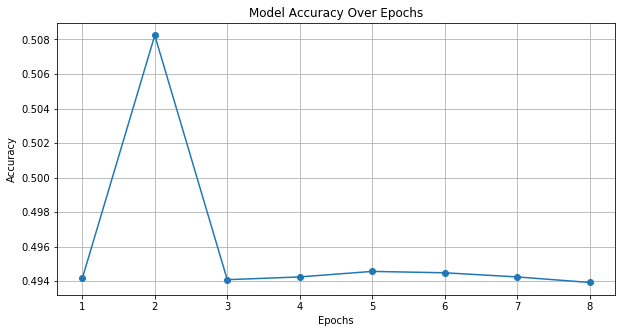

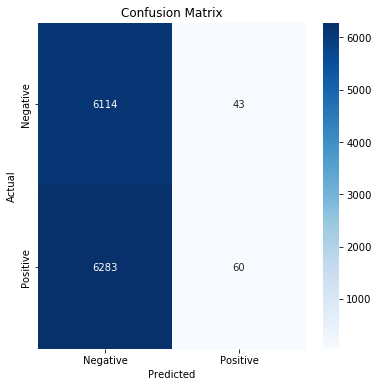

In [7]:
# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Questions
Here are simplified answers to the questions provided:

1. **What is a Recurrent Neural Network (RNN)?**
   An RNN is a type of neural network that is good at processing sequences of data (like sentences or time series). Unlike regular neural networks, RNNs can remember previous inputs using loops within them, which helps in tasks where context is important.

2. **Explain the purpose of the recurrent connection in an RNN.**
   The recurrent connection in an RNN helps it remember past information. This is useful for tasks where you need to understand sequences of data, as it allows the network to keep track of what has happened so far in the sequence.

3. **What are vanishing and exploding gradients, and how do they affect the training of RNNs?**
   Vanishing gradients occur when the values used to update network weights become very small, making learning slow or stopping it entirely. Exploding gradients happen when these values become too large, causing erratic learning. Both problems make training RNNs difficult, especially when dealing with long sequences.

4. **Describe the Long Short-Term Memory (LSTM) network and its key components.**
   LSTMs are a type of RNN designed to avoid the vanishing gradient problem and better remember information over long sequences. They have special structures called gates that regulate the flow of information, deciding what to retain and what to discard.

5. **What is the purpose of the GRU (Gated Recurrent Unit) in RNNs?**
   GRUs are similar to LSTMs as they also use gates to manage information flow and are generally simpler and faster to train. They combine some of the gates found in LSTMs, which simplifies the model without sacrificing too much performance.

6. **Explain the role of the hidden state in an RNN.**
   The hidden state in an RNN acts like its memory. It gets updated every time new data comes in, based on the new data and the previous hidden state. This update helps the RNN keep track of what it has seen so far.

7. **What are some common evaluation metrics used to assess the performance of an RNN?**
   Common metrics include accuracy, Mean Squared Error (MSE) for predicting continuous values, and Cross-Entropy Loss for classification tasks. These help understand how well the RNN is performing its task.

8. **How does data preprocessing impact the performance of RNNs?**
   Proper data preprocessing can significantly improve RNN performance. For text, this might mean converting all text to lowercase, removing punctuation, and converting words to numbers. For time series, this could involve normalizing the data so that all values are on a similar scale.

9. **What is sequence-to-sequence learning in the context of RNNs?**
   Sequence-to-sequence learning involves training an RNN to convert a sequence from one domain (like English text) to another (like French text), often used in tasks like translation or speech recognition.

10. **How can RNNs be used for anomaly detection in time series data?**
    RNNs can learn what normal patterns look like in time series data, and then identify when something unusual happens. This is done by comparing the RNN's predictions based on past data to actual new data and seeing if there's a big difference, which might indicate an anomaly.


---
### Submission
Submit a link to your completed Jupyter Notebook (e.g., on GitHub (private) or Google Colab) with all the cells executed, and answers to the assessment questions included at the end of the notebook.